# Deep Learning models

In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
import random as rn

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

SEED = 2706

In [2]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)

Speaking about the data, we erase the rows corresponding to 'Calm' and 'Surprised' emotions, in accordance with the rest of the study. Also, although we include 'Sex', it will not be used, since we have seen other examples that never train the models with this feature. It seems like it is not relevant.

In [3]:
audios = pd.read_csv("./audio_data/complete_metadata.csv")
audios = audios[['Path', 'Emotion']]
audios = audios[~((audios['Emotion'] == 'Calm') | (audios['Emotion'] == 'Surprised'))]
audios.head()

,Path,Emotion
0,./audio_data/crema-d/1001_DFA_ANG_XX.wav,Angry
1,./audio_data/crema-d/1001_DFA_DIS_XX.wav,Disgust
2,./audio_data/crema-d/1001_DFA_FEA_XX.wav,Fearful
3,./audio_data/crema-d/1001_DFA_HAP_XX.wav,Happy
4,./audio_data/crema-d/1001_DFA_NEU_XX.wav,Neutral


In [4]:
# Encode the emotion labels into numbers 
encoder = LabelEncoder()
audios['Emotion'] = encoder.fit_transform(audios['Emotion'])
# Make sure the encoding worked
audios['Emotion'].value_counts()

Emotion
0    1686
3    1630
2    1628
5    1621
1    1605
4    1358
Name: count, dtype: int64

## Mel Spectrograms for a normal CNN

We will start by fitting a normal CNN. Convolutional networks are great at audio classification because they can summarise with no effort local information from each frame of the recording, adapting to subtle changes that ML models cannot capture. A great visual representation of audio are spectrograms, and in particular, Mel spectrograms. The ones of this kind represent frequencies and amplitudes over time with colours in a way that reassembles human hearing. In short, we will try to teach the CNN how to hear like a human being.

### Preprocessing & Data preparation

The preprocessing function takes an audio file path and returns the Mel spectrogram as an image and then converts the image into a numpy array. Also note that in this case we are loading the audio clips with a SR of 44100Hz, instead of 16000Hz. This is because the RAVDESS and MSD dataset recordings have a higher sampling rate, so maybe the files were getting compressed and lost crucial quality.

In [5]:
def process_audio(path: str) -> np.ndarray:
    """
    Load an audio file, convert it into a mel spectrogram, and return it as a NumPy array.

    Steps:
        - Load audio with a fixed sampling rate of 44.1 kHz (4 seconds, mono).
        - Zero-pad audio shorter than 4 seconds.
        - Compute mel spectrogram with 128 mel bands.
        - Convert spectrogram power values to decibels.
        - Return spectrogram as a NumPy array.

    Args:
        path: Path to the audio file.

    Returns:
        np.ndarray: Mel spectrogram in decibel scale, shape (n_mels, time_frames).
    """
    # Load audio file (mono, 44.1 kHz, max duration 4s)
    audio, sr = librosa.load(path, sr=44100, duration=4, mono=True)

    # Zero-pad audio shorter than 4 seconds
    if len(audio) < 4 * sr:
        audio = np.pad(audio, pad_width=(0, 4 * sr - len(audio)), mode="constant")

    # Compute mel spectrogram
    signal = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)

    # Convert power spectrogram to decibel scale
    signal = librosa.power_to_db(signal, ref=np.min)

    # Convert to NumPy array (explicit, though already np.ndarray)
    image = np.array(signal)

    return image

In [6]:
# Divide the data into features and labels
X_mel = [process_audio(path) for path in audios['Path']]
y_mel = audios['Emotion']

In [7]:
# Divide the data into training and testing sets, with a 80:20 split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_mel, y_mel,
                                                    test_size=0.2,
                                                    random_state=SEED,
                                                    shuffle=True)

In [8]:
# Convert the lists into numpy arrays
X_train_1 = np.array(X_train_1)
X_test_1 = np.array(X_test_1)
y_train_1 = np.array(y_train_1)
y_test_1 = np.array(y_test_1)
# Check the shape of the arrays
print('X_train shape:', X_train_1.shape)
print('X_test shape:', X_test_1.shape)
print('y_train shape:', y_train_1.shape)
print('y_test shape:', y_test_1.shape)

X_train shape: (7622, 128, 345)
X_test shape: (1906, 128, 345)
y_train shape: (7622,)
y_test shape: (1906,)


In [9]:
# Standardize the data by subtracting the mean and dividing by the standard deviation
mean = np.mean(X_train_1)
std = np.std(X_train_1)
X_train_1 = (X_train_1 - mean) / std
X_test_1 = (X_test_1 - mean) / std

In [10]:
# Check the mean and standard deviation
print('Mean:', mean)
print('Standard deviation:', std)
# Check if the data is standardized
print('Mean of standardized data:', np.mean(X_train_1))
print('Standard deviation of standardized data:', np.std(X_train_1))

Mean: 52.78042
Standard deviation: 19.170261
Mean of standardized data: 3.3843758e-06
Standard deviation of standardized data: 1.0000013


In [11]:
# Reshape the data into 4D arrays so that it can be input into the 2D CNN
X_train_1 = X_train_1.reshape(X_train_1.shape[0], 128, 345, 1)
X_test_1 = X_test_1.reshape(X_test_1.shape[0], 128, 345, 1)
# Check the shape of the arrays
print('X_train shape:', X_train_1.shape)
print('X_test shape:', X_test_1.shape)

X_train shape: (7622, 128, 345, 1)
X_test shape: (1906, 128, 345, 1)


In [12]:
# Divide the data into batches of 32 images
batch_size = 32
# Make a training dataset from the training set
train_dataset_1 = tf.data.Dataset.from_tensor_slices((X_train_1, y_train_1))
# Shuffle, batch, and prefetch the data
train_dataset_1 = train_dataset_1.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# Make a testing dataset from the testing set
test_dataset_1 = tf.data.Dataset.from_tensor_slices((X_test_1, y_test_1))
# Shuffle, batch, and prefetch the data
test_dataset_1 = test_dataset_1.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Network

Here we define the structure of the CNN, after having formatted the input data. The code explains itself in this part.

In [13]:
# Define the CNN model
model_mel = tf.keras.Sequential([
    # First convolutional layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 345, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # Batch normalization maintains the 0 mean and 1 standard deviation
    tf.keras.layers.BatchNormalization(),
    # Second convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    # Third convolutional layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    # Fourth convolutional layer
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    # Global average pooling layer averages the values in each feature map into
    # a single value and flattens the result into a (None, 256) array
    tf.keras.layers.GlobalAveragePooling2D(),
    # Dropout layer randomly sets 50% of the activations to zero
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [14]:
# Compile the model
model_mel.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

We include regularisation techniques to avoid overfitting and getting lost while training. This two option boost our training.

In [15]:
# Create a callback that stops training when the validation loss plateaus or increases
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode = 'min')
# Create a callback that adjusts the learning rate gradually
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.2,
                                                    min_lr=0.000001,
                                                    patience=3,
                                                    mode='min')
# Train the model
history_mel = model_mel.fit(train_dataset_1,
                    epochs=50,
                    validation_data=test_dataset_1,
                    callbacks=[early_stop, lr_scheduler])

Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 65s 261ms/step - accuracy: 0.3095 - loss: 1.8262 - val_accuracy: 0.1936 - val_loss: 1.8324 - learning_rate: 0.0010
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 63s 263ms/step - accuracy: 0.3668 - loss: 1.5813 - val_accuracy: 0.3395 - val_loss: 1.5750 - learning_rate: 0.0010
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 63s 264ms/step - accuracy: 0.4127 - loss: 1.4863 - val_accuracy: 0.3945 - val_loss: 1.4867 - learning_rate: 0.0010
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 62s 261ms/step - accuracy: 0.4290 - loss: 1.4471 - val_accuracy: 0.3809 - val_loss: 1.6575 - learning_rate: 0.0010
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 61s 257ms/step - accuracy: 0.4481 - loss: 1.3846 - val_accuracy: 0.2749 - val_loss: 2.6230 - learning_rate: 0.0010
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 61s 256ms/step - accuracy: 0.4727 - loss: 1.3298 - val_accuracy: 0.3342 - val_loss: 2.1128 - learning_rate: 0.0010
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 62s 261ms/step - accuracy: 0.5

In [16]:
# Save the model
model_mel.save('./models/emotion_recognition_mel_spec.keras')

### Results

Let's print some images to see how the model performs.

We start by the learning curves, that show the traning and testing losses and accuracies. It is a great way of visualising if the model overfits and if the training is serving its purpose (result get better over time).

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.5862 - loss: 1.0827
Accuracy of our model on test data :  58.18467736244202 %


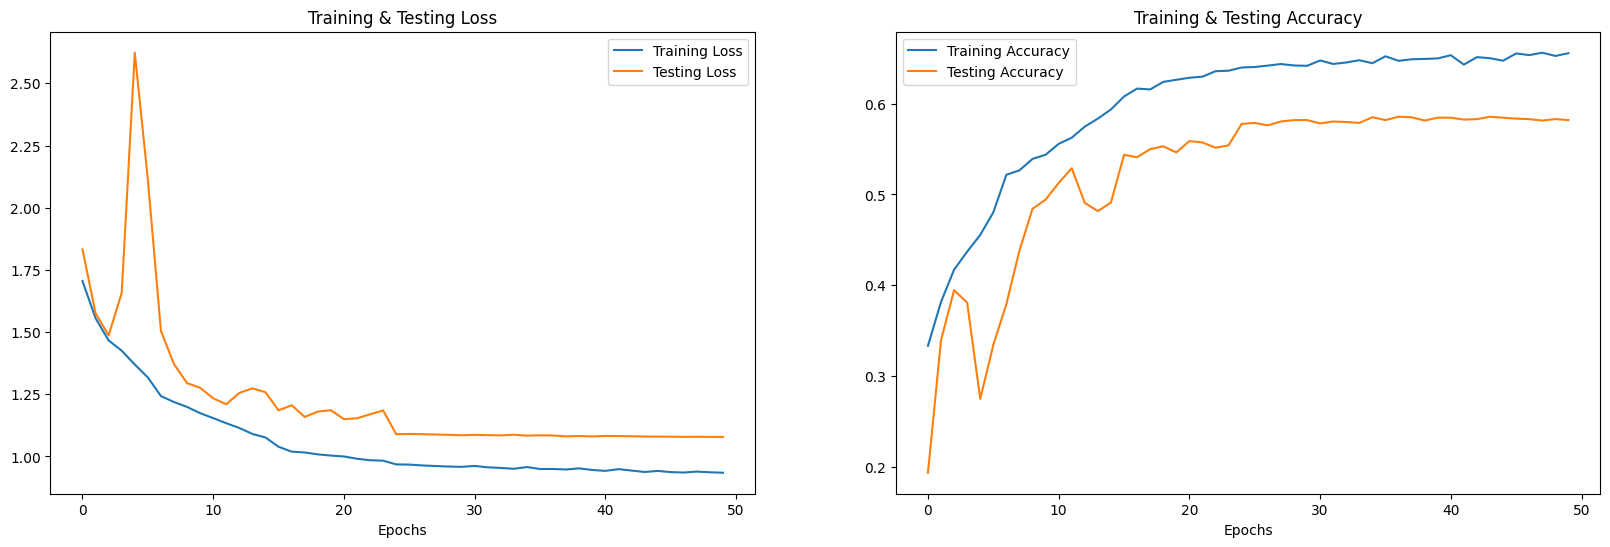

In [17]:
print("Accuracy of our model on test data : " , model_mel.evaluate(X_test_1,y_test_1)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history_mel.history['accuracy']
train_loss = history_mel.history['loss']
test_acc = history_mel.history['val_accuracy']
test_loss = history_mel.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss , label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc , label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [18]:
# Measure the precision and recall
y_pred = model_mel.predict(X_test_1)
# Convert the predictions into one-hot encoded vectors
y_pred = np.argmax(y_pred, axis=1)
# Plot the classification report
print(classification_report(y_test_1, y_pred, target_names=encoder.classes_))

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step
              precision    recall  f1-score   support

       Angry       0.78      0.71      0.74       343
     Disgust       0.63      0.52      0.57       338
     Fearful       0.54      0.44      0.48       339
       Happy       0.54      0.57      0.55       307
     Neutral       0.53      0.65      0.59       253
         Sad       0.50      0.62      0.55       326

    accuracy                           0.58      1906
   macro avg       0.59      0.58      0.58      1906
weighted avg       0.59      0.58      0.58      1906



60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step


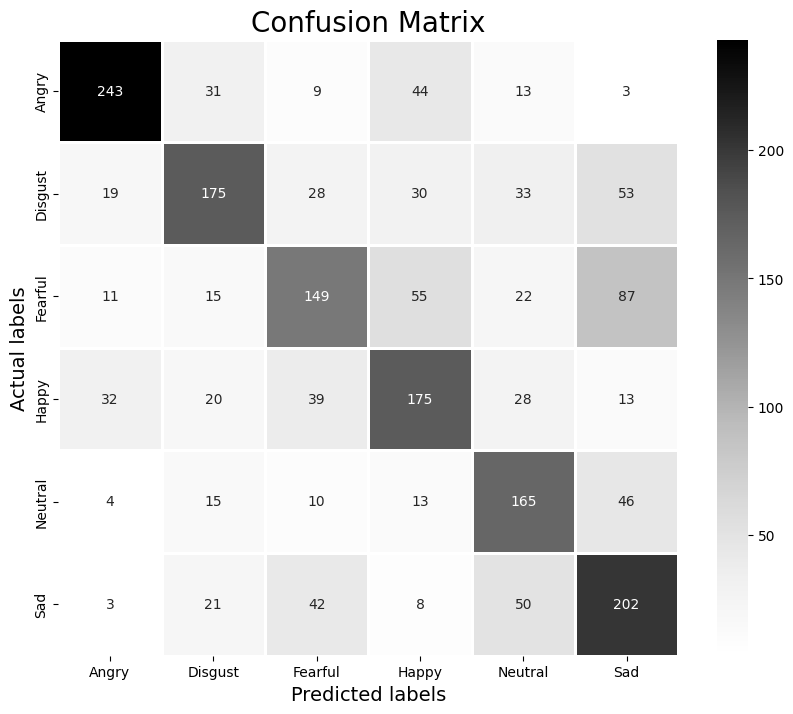

In [19]:
# Plot the confusion matrix for the validation set
# Get the predictions for the test data
y_pred = model_mel.predict(X_test_1)
# Convert the predictions into one-hot encoded vectors
y_pred = np.argmax(y_pred, axis=1)
# Get the confusion matrix
cm = tf.math.confusion_matrix(y_test_1, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
# Make the index and column labels the emotion names
cm = pd.DataFrame(cm.numpy(), index=encoder.classes_, columns=encoder.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys', linewidths=1, linecolor='white')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted labels', size=14)
plt.ylabel('Actual labels', size=14)
plt.show()

## MFCCs for an CNN+LSTM hybrid

Now, let's try something special.

On the one hand, MFCCs, which are explained in the memoir. In short, they capture numerically what Mel spectrograms do, but with more precision.

On the other hand, we mix two architectures that serve different purposes. CNNs capture local characteristics by its pooling techniques and patching, whereas LSTMs have the ability to remember. The idea is to patch the clips, and in some way relate them over time.

### Preprocessing & Data preparation

This time we will be adding data augmentation, to see if it improves the performance. Also, we will be using a similar preprocessing function, which actually extracts the MFCCs and augment the data. 

To avoid data leakage, we will split the data into train and test before applying this function.

In [20]:
# --- Augmentation functions ---
def add_noise(audio: np.ndarray, noise_factor: float = 0.005) -> np.ndarray:
    """
    Add Gaussian noise to an audio signal.

    Args:
        audio: Input audio signal.
        noise_factor: Scaling factor for the noise amplitude.

    Returns:
        np.ndarray: Noisy audio signal.
    """
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise


def pitch_shift(audio: np.ndarray, sr: int, n_steps: int = 2) -> np.ndarray:
    """
    Apply pitch shifting to an audio signal.

    Args:
        audio: Input audio signal.
        sr: Sampling rate of the audio signal.
        n_steps: Number of semitones to shift (positive or negative).

    Returns:
        np.ndarray: Pitch-shifted audio signal.
    """
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)


# --- MFCC extraction function ---
def extract_mfcc(audio: np.ndarray, sr: int = 44100) -> np.ndarray:
    """
    Extract MFCC features from an audio signal.

    Steps:
        - Pad or truncate audio to 4 seconds.
        - Compute MFCC with 128 coefficients.

    Args:
        audio: Input audio signal.
        sr: Sampling rate of the audio signal (default is 44.1 kHz).

    Returns:
        np.ndarray: MFCC matrix of shape (n_mfcc, time_frames).
    """
    # Pad audio to 4 seconds if shorter
    if len(audio) < 4 * sr:
        audio = np.pad(audio, pad_width=(0, 4 * sr - len(audio)), mode="constant")

    # Truncate to exactly 4 seconds if longer
    audio = audio[: 4 * sr]

    # Compute MFCC features
    signal = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=128)

    return np.array(signal)

In [21]:
# --- 1. Split ---
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    audios['Path'], audios['Emotion'],
    test_size=0.2, random_state=0, shuffle=True
)

# --- 2. Train preprocessing with augmentations ---
X_train_mfcc, y_train_final = [], []
sr = 44100

for path, label in zip(X_train_paths, y_train):
    audio, _ = librosa.load(path, sr=sr, duration=4, mono=True)

    # Original
    X_train_mfcc.append(extract_mfcc(audio, sr))
    y_train_final.append(label)

    # Augmentation 1
    aug1 = add_noise(audio)
    X_train_mfcc.append(extract_mfcc(aug1, sr))
    y_train_final.append(label)

    # Augmentation 2
    aug2 = pitch_shift(audio, sr, n_steps=2)
    X_train_mfcc.append(extract_mfcc(aug2, sr))
    y_train_final.append(label)

# --- 3. Test preprocessing ---
X_test_mfcc = [extract_mfcc(librosa.load(path, sr=sr, duration=4, mono=True)[0], sr) for path in X_test_paths]
y_test = np.array(y_test)

In [22]:
# --- 4. Format cleaning ---
X_train = np.array(X_train_mfcc)
y_train = np.array(y_train_final)
X_test = np.array(X_test_mfcc)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (22866, 128, 345)
y_train: (22866,)
X_test: (1906, 128, 345)
y_test: (1906,)


In [23]:
# --- 5. Standardisation ---
mean = np.mean(X_train)
std = np.std(X_train)
X_train_2 = (X_train - mean) / std
X_test_2 = (X_test - mean) / std

In [24]:
# Check the mean and standard deviation
print('Mean:', mean)
print('Standard deviation:', std)
# Check if the data is standardized
print('Mean of standardized data:', np.mean(X_train_2))
print('Standard deviation of standardized data:', np.std(X_train_2))

Mean: -3.363373694813311
Standard deviation: 48.89815885137481
Mean of standardized data: -4.579422916958611e-16
Standard deviation of standardized data: 1.0000000000000147


In [25]:
# --- 6. Formatting ---
X_train = X_train.reshape(X_train.shape[0], 128, 345, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 345, 1)

In [26]:
# Reshape the data into 4D arrays so that it can be input into the 2D CNN
X_train_2 = X_train_2.reshape(X_train_2.shape[0], 128, 345, 1)
X_test_2 = X_test_2.reshape(X_test_2.shape[0], 128, 345, 1)
# Check the shape of the arrays
print('X_train shape:', X_train_2.shape)
print('X_test shape:', X_test_2.shape)

X_train shape: (22866, 128, 345, 1)
X_test shape: (1906, 128, 345, 1)


In [27]:
# Divide the data into batches of 32 images
batch_size = 32
# Make a training dataset from the training set
train_dataset_2 = tf.data.Dataset.from_tensor_slices((X_train_2, y_train))
# Shuffle, batch, and prefetch the data
train_dataset_2 = train_dataset_2.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# Make a testing dataset from the testing set
test_dataset_2 = tf.data.Dataset.from_tensor_slices((X_test_2, y_test))
# Shuffle, batch, and prefetch the data
test_dataset_2 = test_dataset_2.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [28]:
# Save in case we want to test the model with other configurations
np.save("./features/X_train_CRNN.npy", X_train)
np.save("./features/y_train_CRNN.npy", y_train)
np.save("./features/X_test_CRNN.npy", X_test)
np.save("./features/y_test_CRNN.npy", y_test)

### Network

Here we build the hybrid network, also called CRNN in some articles. Again, the code is self-explanatory.

In [29]:
# Build a CRNN model
model_crnn = tf.keras.Sequential([
    # First convolutional layer
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 345, 1), padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    # Second convolutional layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    # Third convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    # Fourth convolutional layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    # Global average pooling layer averages the values in each feature map into
    # a single value and flattens the result into a (none, 256) array
    tf.keras.layers.GlobalAveragePooling2D(),
    # Reshape layer to convert (none, 256) to (none, 1, 256) as the LSTM layer
    # requires a 3D input
    tf.keras.layers.Reshape((1, 128)),
    # First bidirectional recurrent layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    # Second bidirectional recurrent layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    # Dropout layer randomly sets 50% of the activations to zero
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [30]:
# Compile the model
model_crnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
# fit the model
history_crnn = model_crnn.fit(train_dataset_2,
                    epochs=30,
                    validation_data=test_dataset_2,
                    callbacks=[early_stop, lr_scheduler])

Epoch 1/30
715/715 ━━━━━━━━━━━━━━━━━━━━ 203s 261ms/step - accuracy: 0.3152 - loss: 1.6764 - val_accuracy: 0.3353 - val_loss: 1.6390 - learning_rate: 0.0010
Epoch 2/30
715/715 ━━━━━━━━━━━━━━━━━━━━ 180s 252ms/step - accuracy: 0.4062 - loss: 1.4484 - val_accuracy: 0.4633 - val_loss: 1.3500 - learning_rate: 0.0010
Epoch 3/30
715/715 ━━━━━━━━━━━━━━━━━━━━ 180s 252ms/step - accuracy: 0.4597 - loss: 1.3513 - val_accuracy: 0.4397 - val_loss: 1.3256 - learning_rate: 0.0010
Epoch 4/30
715/715 ━━━━━━━━━━━━━━━━━━━━ 179s 251ms/step - accuracy: 0.5027 - loss: 1.2674 - val_accuracy: 0.5299 - val_loss: 1.2059 - learning_rate: 0.0010
Epoch 5/30
715/715 ━━━━━━━━━━━━━━━━━━━━ 179s 250ms/step - accuracy: 0.5373 - loss: 1.2007 - val_accuracy: 0.5362 - val_loss: 1.1651 - learning_rate: 0.0010
Epoch 6/30
715/715 ━━━━━━━━━━━━━━━━━━━━ 176s 246ms/step - accuracy: 0.5672 - loss: 1.1331 - val_accuracy: 0.5666 - val_loss: 1.1085 - learning_rate: 0.0010
Epoch 7/30
715/715 ━━━━━━━━━━━━━━━━━━━━ 174s 243ms/step - accura

In [32]:
# Save the model
model_crnn.save('./models/emotion_recognition_crnn.keras')

### Results

We print exactly the same evaluations, to have a fair comparison.

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.6753 - loss: 0.9325
Accuracy of our model on test data :  68.20566654205322 %


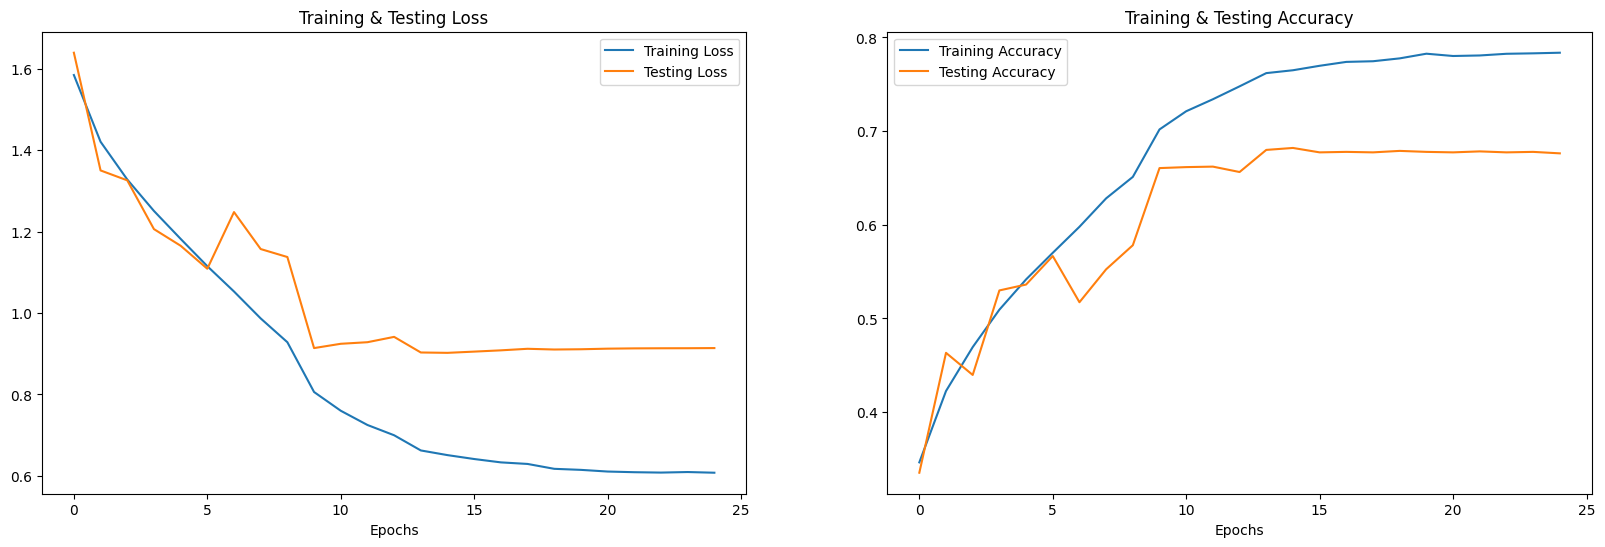

In [33]:
print("Accuracy of our model on test data : " , model_crnn.evaluate(X_test_2, y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history_crnn.history['accuracy']
train_loss = history_crnn.history['loss']
test_acc = history_crnn.history['val_accuracy']
test_loss = history_crnn.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss , label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc , label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [34]:
# Measure the precision and recall
y_pred = model_crnn.predict(X_test_2)
# Convert the predictions into one-hot encoded vectors
y_pred = np.argmax(y_pred, axis=1)
# Plot the classification report
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step
              precision    recall  f1-score   support

       Angry       0.77      0.74      0.76       344
     Disgust       0.64      0.60      0.62       304
     Fearful       0.60      0.62      0.61       302
       Happy       0.71      0.63      0.67       354
     Neutral       0.72      0.77      0.74       280
         Sad       0.64      0.74      0.69       322

    accuracy                           0.68      1906
   macro avg       0.68      0.68      0.68      1906
weighted avg       0.68      0.68      0.68      1906



60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step


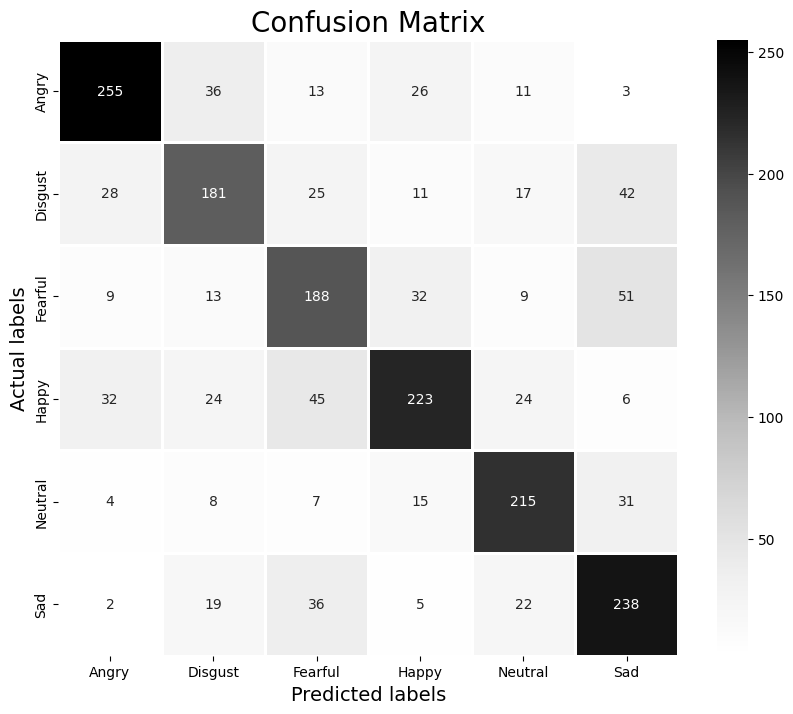

In [35]:
# Plot the confusion matrix for the validation set
# Get the predictions for the test data
y_pred = model_crnn.predict(X_test_2)
# Convert the predictions into one-hot encoded vectors
y_pred = np.argmax(y_pred, axis=1)
# Get the confusion matrix
cm = tf.math.confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
# Make the index and column labels the emotion names
cm = pd.DataFrame(cm.numpy(), index=encoder.classes_, columns=encoder.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys', linewidths=1, linecolor='white')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted labels', size=14)
plt.ylabel('Actual labels', size=14)
plt.show()